### Эконометрика. Домашняя работа №2

#### Задание

1. Выбрать два инструмента на Российском рынке. Загрузить данные с finam.ru
2. Для каждого инструмента подобрать наилучшую ARMA/GARCH модель
3. Для каждой из полученных моделей расчитать годовую волатильность
4. Приветси два графика волатильности в процентах в годовом выражении
5. Нарисовать графики и сделать выводы
6. Спрогнозировать волатильность на два дня вперед

#### Решение.

### Подготовка данных

В качестве двух активов для исследования были выбраны акции ОАО "Мегафон" и ОАО "МТС". Дневные данные за период с 12.11.2012 (IPO OAO "Мегафон") по 10.12.2016 были загружены с сайта компании Финам.

Для начала необходимо прочитать загруженные данные. Для работы с данными будем использовать библиотеку Pandas.

In [1]:
import warnings
warnings.simplefilter('ignore')

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок

mfon_df = pd.read_csv('MFON_121128_161210.csv', parse_dates=['<DATE>'], index_col='<DATE>')
mtss_df = pd.read_csv('MTSS_121128_161210.csv', parse_dates=['<DATE>'], index_col='<DATE>')

Нарисуем графики цен выбранных акций.

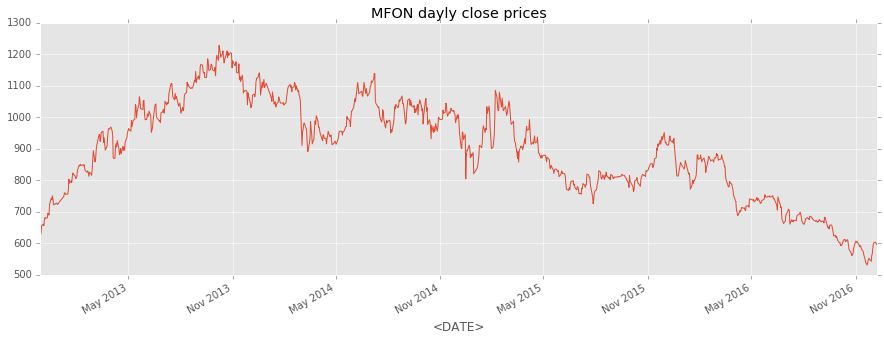

In [2]:
mfon_plt = mfon_df['<CLOSE>'].plot(title='MFON dayly close prices')

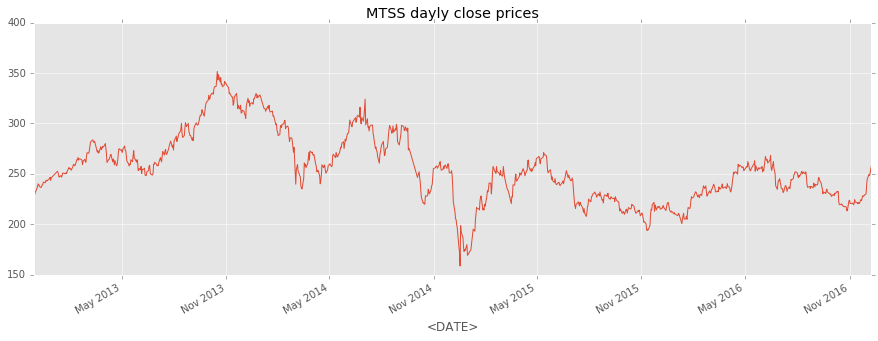

In [3]:
mtss_plt = mtss_df['<CLOSE>'].plot(title='MTSS dayly close prices')

Для начала необходимо убедиться, что мы работаем со стационарными рядами, проведем ADF тест.

In [4]:
from arch.unitroot import ADF
adf = ADF(mtss_df['<CLOSE>'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.643
P-value                         0.084
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [5]:
adf = ADF(mfon_df['<CLOSE>'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.344
P-value                         0.609
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Как видно из результатов тестов, стационарность цен МТС может быть принята лишь на уровне значимости 90%, в то время как даже на таком низком уровне значимости стационарность цен Мегафона мы принять не можем.

Далее будем работать с данными дневных доходностей.

In [6]:
mtss_returns = 100 * mtss_df['<CLOSE>'].pct_change().dropna()
mfon_returns = 100 * mfon_df['<CLOSE>'].pct_change().dropna()

Посмотрим на то, что у нас получилось:

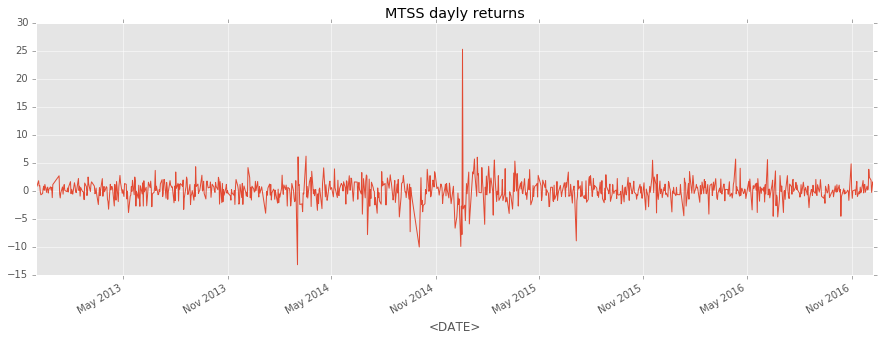

In [7]:
mtss_rplt = mtss_returns.plot(title='MTSS dayly returns')

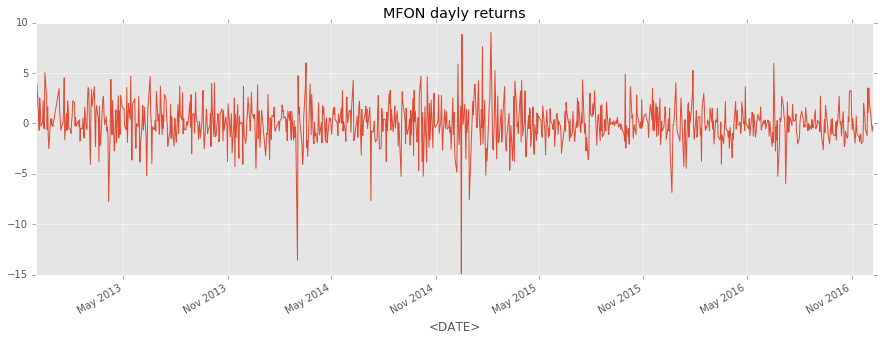

In [8]:
mfon_rplt = mfon_returns.plot(title='MFON dayly returns')

Проверим полученные ряды доходностей на стационарность.

In [9]:
adf = ADF(mtss_returns)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -10.099
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [10]:
adf = ADF(mfon_returns)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -18.032
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Из теста можно видеть, что в отличии от ценовых рядов ряды доходностей является стационарным, их мы и будем использовать для дальнейших исследований.

Теперь мы можем строить нашу ARMA/GARCH модель. Общий план действий для построения модели следующий:

1. Найти параметры ARMA модели для нашего ряда (по критерию Акаики)
2. Протестировать на гетероскедастичность
3. Если наблюдается гетероскедастичность, то необходимо подобрать оптимальные параметры для GARCH модели для моделирования волатильности

### Выбор ARMA модели для рядов доходностей выбранных компаний

Для выбора параметров ARMA модели, необходимо посмотреть, есть ли взаимосвязь между доходностями с прошлыми значениями доходностей и ошибками. 

Для этого будем использовать корелограммы (ACF/PACF).

Сначала посмотрим на корелляции для Мегафона:

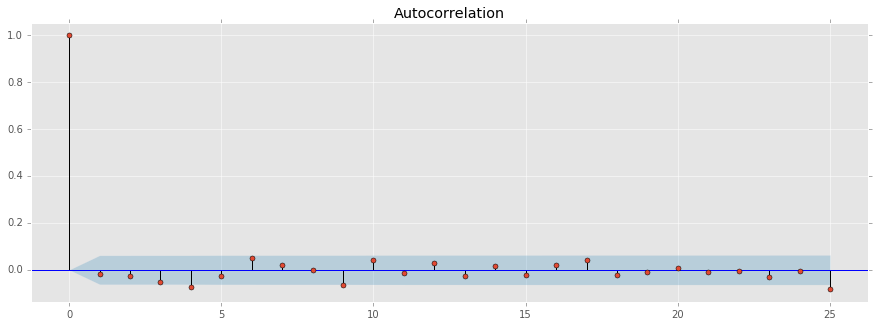

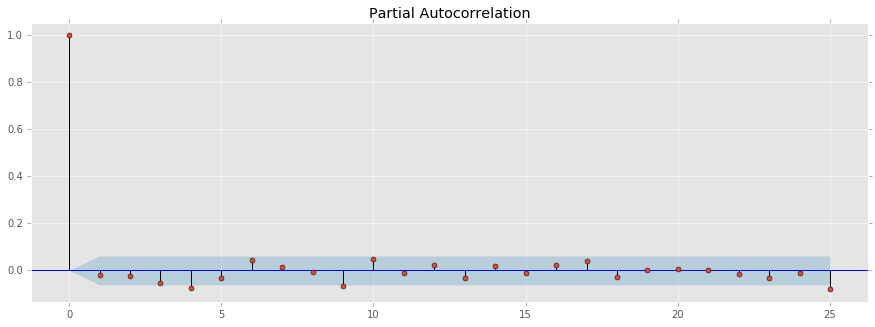

In [11]:
fig = sm.graphics.tsa.plot_acf(mfon_returns, lags=25)
fig = sm.graphics.tsa.plot_pacf(mfon_returns, lags=25)

Для ряда доходностей компании Мегафон мы можем наблюдать отсутствие корелляций значений и ошибок, следовательно, процесс представляет собой белый шум.

Посмотрим на ряд доходностей компании МТС.

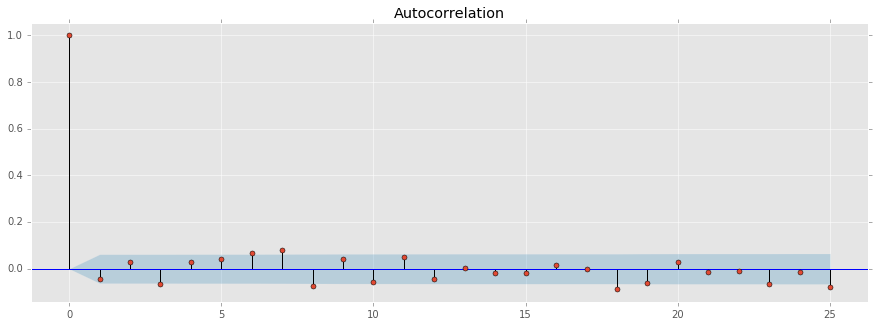

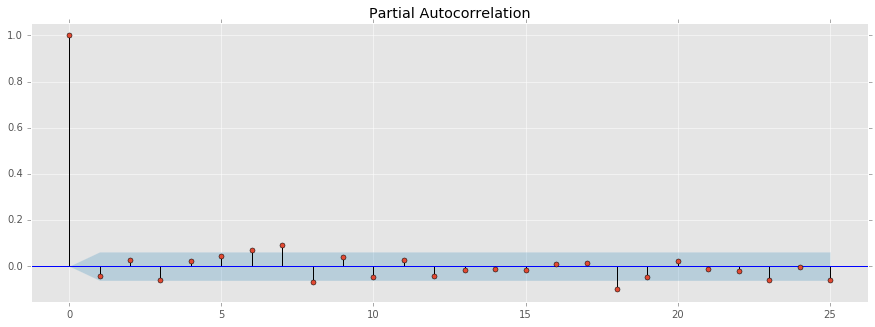

In [12]:
fig = sm.graphics.tsa.plot_acf(mtss_returns.values.squeeze(), lags=25)
fig = sm.graphics.tsa.plot_pacf(mtss_returns, lags=25)

Для ряда доходностей МТС мы можем сделать такой же вывод как и для ряда доходностей Мегафона.

Таким образом мы получили, что в наилучшей моделью для наших рядов является ARMA(0, 0).

Далее проверим, необходимо ли учитывать в модели ARCH эффект.

### Тестирование на гетероскедастичность

Для тестирования будем использовать тест Энгла (ARCH).

In [13]:
from arch.univariate import ARX, ConstantMean
from statsmodels.sandbox.stats.diagnostic import het_arch

# оцениваем ARMA(0,0) модель для MTSS и MFON
cm_mtss = ConstantMean(mtss_returns)
res_mtss = cm_mtss.fit(update_freq=5)
cm_mfon = ConstantMean(mfon_returns)
res_mfon = cm_mfon.fit(update_freq=5)

# проводим ARCH тест и смотрим на p-value для F-теста
mtss_ftest_pvalue = het_arch(res_mtss.resid)[3]
mfon_ftest_pvalue = het_arch(res_mfon.resid)[3]

print("mtss_ftest_pvalue: %f" % mtss_ftest_pvalue)
print("mfon_ftest_pvalue: %f" % mfon_ftest_pvalue)

mtss_ftest_pvalue: 0.000230
mfon_ftest_pvalue: 0.000000


Мы получили слишком малые P-значения для обоих тестов, что говорит о том, что ошибка первого рода (отвергнутая гипотиза об отсутствии гетероскедастичности при ее фактическом отсутствии) очень мала. Таким образом мы можем сделать статистический вывод о наличии гетероскедастичности.

Итак, мы выявили наличие GARCH эффекта в наших рядах доходностей, теперь необходимо подобрать оптимальные параметры для GARCH модели. Это мы сделаем в следующей части.

### Подбор оптимальных параметров GARCH модели

Для GARCH моделей необходимо подобрать оптимальные значения параметров $p$ и $q$. Для подбора реализуем соответствующую функцию, которая методом перебора будет находить очередную модель с меньшим значением критерия Акаики и распечатывать основную информацию для этой модели.

In [14]:
from arch import arch_model
from scipy import stats

def find_garch(values, max_p=5, max_q=5):
    def lr_test(r1, r2):
        return 1 - stats.chi2.cdf(
            abs(2 * (r1.loglikelihood - r2.loglikelihood)),
            abs(r1.num_params - r2.num_params)
        )
    best_model = {"p": -1, "q": -1, "AIC": float('+inf'), "res": 0}
    initialized = False
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            model = arch_model(values, p=p, q=q)
            res = model.fit(disp = 'off')
            if (res.aic < best_model["AIC"]):
                if (initialized):
                    old_res = best_model["res"]
                    best_model = {"p": p, "q": q, "AIC": res.aic, 'res': res}
                    print("Найдена модель: p = %d, q = %d, AIC = %f"
                          % (p, q, res.aic))
                    if (res.num_params != old_res.num_params):
                        print("LR test p-value = %f" % (lr_test(res, old_res)))
                else:
                    best_model = {"p": p, "q": q, "AIC": res.aic, 'res': res}
                    print("Найдена модель: p = %d, q = %d, AIC = %f" % (p, q, res.aic))

                initialized = True

Используя нашу функцию произведем поиск лучших моделей.

Для доходностей MFON:

In [15]:
find_garch(mfon_returns)

Найдена модель: p = 1, q = 1, AIC = 4205.239650
Найдена модель: p = 1, q = 3, AIC = 4202.414839
LR test p-value = 0.032962


Для доходностей MTSS:

In [16]:
find_garch(mtss_returns)

Найдена модель: p = 1, q = 1, AIC = 4011.855029
Найдена модель: p = 1, q = 2, AIC = 4006.973962
LR test p-value = 0.008711
Найдена модель: p = 1, q = 5, AIC = 4005.875069
LR test p-value = 0.068812
Найдена модель: p = 3, q = 5, AIC = 4005.209901
LR test p-value = 0.097045


Посмотрим на полученные "лучшие" по Акаике модели.

In [17]:
model = arch_model(mfon_returns, p=1, q=3)
res = model.fit(disp = 'off')
print(res.summary())
model = arch_model(mtss_returns, p=3, q=5)
res = model.fit(disp = 'off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                <CLOSE>   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2095.21
Distribution:                  Normal   AIC:                           4202.41
Method:            Maximum Likelihood   BIC:                           4231.92
                                        No. Observations:                 1009
Date:                Thu, Dec 22 2016   Df Residuals:                     1003
Time:                        01:01:55   Df Model:                            6
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             0.0257  5.879e-02      0.437      0.6

Как мы можем видеть, часть параметров полученных моделей незначима. Сокращая число параметров до тех пор пока все коэффициенты не станут значимыми для обоих рядов мы получаем GARCH(1, 1) модель.

Выведем основную информацию для полученных моделей.

In [18]:
model = arch_model(mfon_returns, p=1, q=1)
res = model.fit(disp = 'off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                <CLOSE>   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2098.62
Distribution:                  Normal   AIC:                           4205.24
Method:            Maximum Likelihood   BIC:                           4224.91
                                        No. Observations:                 1009
Date:                Thu, Dec 22 2016   Df Residuals:                     1005
Time:                        01:01:58   Df Model:                            4
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             0.0255  5.920e-02      0.431      0.6

In [19]:
model = arch_model(mtss_returns, p=1, q=1)
res = model.fit(disp = 'off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                <CLOSE>   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -2001.93
Distribution:                  Normal   AIC:                           4011.86
Method:            Maximum Likelihood   BIC:                           4031.49
                                        No. Observations:                 1000
Date:                Thu, Dec 22 2016   Df Residuals:                      996
Time:                        01:01:59   Df Model:                            4
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             0.0799  5.418e-02      1.474      0.1

Теперь мы можем включить GARCH(1,1) эффект в нашу модель.

In [20]:
from arch.univariate import GARCH

cm_mtss.volatility = GARCH(p=1, q=1)
cm_mfon.volatility = GARCH(p=1, q=1)

mtss_res = cm_mtss.fit(disp = 'off')
mfon_res = cm_mfon.fit(disp = 'off')

Нарисуем исторические значения волатильности

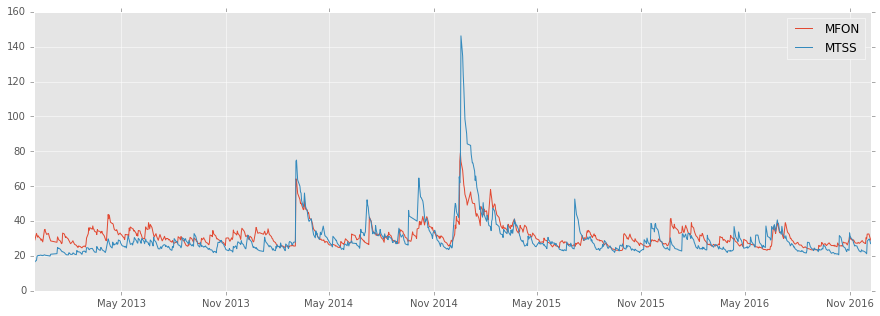

In [21]:
mfon_vol = mfon_res.conditional_volatility * np.sqrt(252)
mtss_vol = mtss_res.conditional_volatility * np.sqrt(252)

p = plt.plot(title='ASSAD')
p1 = plt.plot(mfon_vol)
p2 = plt.plot(mtss_vol)
p = plt.legend((p1[0], p2[0]), ('MFON', 'MTSS'))

### Прогнозирование волатильности

Построенная модель может использоваться для прогнозирования волатильности. Давайте попробуем спрогнозировать волатильность на один торговый день вперед.

In [22]:
last_sigma = mtss_res.conditional_volatility[len(mtss_res.conditional_volatility) - 1]
last_resid = mtss_res.resid[len(mtss_res.conditional_volatility) - 1]

np.sqrt(mtss_res.params['omega'] 
        + mtss_res.params['alpha[1]'] * last_resid**2 
        + last_sigma**2 * mtss_res.params['beta[1]']) * np.sqrt(252)

26.409813536204808

In [23]:
last_sigma = mfon_res.conditional_volatility[len(mfon_res.conditional_volatility) - 1]
last_resid = mfon_res.resid[len(mfon_res.conditional_volatility) - 1]

np.sqrt(mfon_res.params['omega'] 
        + mfon_res.params['alpha[1]'] * last_resid**2 
        + last_sigma**2 * mfon_res.params['beta[1]']) * np.sqrt(252)

27.790068941278314

### Выводы

В результате проведенной работы удалось посторить модель для оценки и прогнозирования волатильности для акций двух компаний: ПАО МТС и ПАО Мегафон. С помощью графика волатильностей можно соотнести средние значения волатильностей для этих инструментов. Так можно наблюдать, что в начальный период своего существования акции мегафона были подвержены большим колебаниям по сравнению с МТС, в то время как в последние годы для этих бумаг наблюдаются сопоставимые значения волатильности. В отдельные периоды, когда бумаги подвержены значительной волатильности по сравнению со своими средними значениями, для акций компании МТС можно наблюдать даже большие колебания.